# Anticipez les besoins en consommation électrique de bâtiments

* Ville neutre en emissione de carbonne en 2050  
* Prédire les émission de co2 et la consommation totale d'énergie des batiments pour lesquelles pas de mesure  
* Évaluer l'interet de l'ENERGY STAR SCORE pour la prédiction d'émissions

* **1. Réaliser une courte analyse exploratoire**  
* **2. Tester différents modèles de prédiction afin de réponf=dre au mieux à la problématique**
* **3. Attention à la fuite de données**

* choisir les variables à utiliser
* data leak
* regresseur differents (min 1 linéaire, 1 non linéaire
* validation croisée lors de l'optimisation des hyperparams
* justifier le choix de l'un des regresseurs
* choisir métrique poour l'optimisation
* Explorer differents score et indic de performances
* présentation du plus simple au plus complexe
* encodage adapté des var catégorielles
* Normalisation des variables ou transformation de leur distrib si besoin

In [3]:
import dill
dill.load_session('kernels/p4_explor_kernel.db')

KeyError: 'file'

In [1]:
import os

import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from scipy.stats import shapiro

from sklearn.preprocessing import LabelEncoder

In [2]:
pd.set_option("display.max_colwidth", 1000)

## 1. IMPORT DES DONNÉES

In [10]:
df_2015 = pd.read_csv(r'D:\Work\OC_DS_P4\2015-building-energy-benchmarking.csv')
df_2016 = pd.read_csv(r'D:\Work\OC_DS_P4\2016-building-energy-benchmarking.csv')

In [ ]:
df_2015 = pd.read_csv(r'E:\t\Cours Open Classeroom\DATA SCIENCE\Projet 4\data\2015-building-energy-benchmarking.csv')
df_2016 = pd.read_csv(r'E:\t\Cours Open Classeroom\DATA SCIENCE\Projet 4\data\2016-building-energy-benchmarking.csv')

In [6]:
df_2015 = pd.read_csv(r'C:\Users\t.favrel\Downloads\data p4\2015-building-energy-benchmarking.csv')
df_2016 = pd.read_csv(r'C:\Users\t.favrel\Downloads\data p4\2016-building-energy-benchmarking.csv')

In [6]:
with open(r'D:\Work\OC_DS_P4\socrata_metadata_2015-building-energy-benchmarking.json') as json_data:
    metaData_2015 = json.load(json_data)
    
with open(r'D:\Work\OC_DS_P4\socrata_metadata_2016-building-energy-benchmarking.json') as json_data:
    metaData_2016 = json.load(json_data)

In [7]:
# Données relatives aux colonnes
meta_col_2015 = pd.DataFrame.from_dict(metaData_2015['columns'])
meta_col_2016 = pd.DataFrame.from_dict(metaData_2016['columns'])

## 2. APERÇU DES DONNÉES

In [11]:
def df_display_shape(df, name='_'):
    '''
    Affiche le nombre de lignes et de colonnes d'un DataFrame
    '''
    if name != '_':
        print(f'{name} contient {df.shape[0]} lignes et {df.shape[1]} colonnes')
    else:
        print(f'Le DataFrame contient {df.shape[0]} lignes et {df.shape[1]} colonnes')

In [12]:
df_display_shape(df_2015)
df_2015.head(4)

Le DataFrame contient 3340 lignes et 47 colonnes


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081


In [13]:
df_display_shape(df_2016)
df_2016.head(4)

Le DataFrame contient 3376 lignes et 46 colonnes


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67


### 2.a Colonnes 

In [14]:
col_2015 = set(df_2015.columns)
col_2016 = set(df_2016.columns)

In [15]:
inter = col_2015.intersection(col_2016) # Dans 2015 et 2016
only_2015 = col_2015.difference(col_2016) # Uniquement dans 2015
only_2016 = col_2016.difference(col_2015) # Uniquement dans 2016

In [16]:
print(f"Il y a {len(inter)} colonnes présentes en 2015 et 2016\n\
Il y a {len(only_2015)} colonnes uniquement en 2015 et {len(only_2016)} colonnes uniquement en 2016.")

Il y a 37 colonnes présentes en 2015 et 2016
Il y a 10 colonnes uniquement en 2015 et 9 colonnes uniquement en 2016.


In [17]:
inter, only_2015, only_2016

({'BuildingType',
  'ComplianceStatus',
  'CouncilDistrictCode',
  'DataYear',
  'DefaultData',
  'ENERGYSTARScore',
  'Electricity(kBtu)',
  'Electricity(kWh)',
  'LargestPropertyUseType',
  'LargestPropertyUseTypeGFA',
  'ListOfAllPropertyUseTypes',
  'NaturalGas(kBtu)',
  'NaturalGas(therms)',
  'Neighborhood',
  'NumberofBuildings',
  'NumberofFloors',
  'OSEBuildingID',
  'Outlier',
  'PrimaryPropertyType',
  'PropertyGFABuilding(s)',
  'PropertyGFAParking',
  'PropertyGFATotal',
  'PropertyName',
  'SecondLargestPropertyUseType',
  'SecondLargestPropertyUseTypeGFA',
  'SiteEUI(kBtu/sf)',
  'SiteEUIWN(kBtu/sf)',
  'SiteEnergyUse(kBtu)',
  'SiteEnergyUseWN(kBtu)',
  'SourceEUI(kBtu/sf)',
  'SourceEUIWN(kBtu/sf)',
  'SteamUse(kBtu)',
  'TaxParcelIdentificationNumber',
  'ThirdLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt',
  'YearsENERGYSTARCertified'},
 {'2010 Census Tracts',
  'City Council Districts',
  'Comment',
  'GHGEmissions(MetricTonsCO2e)',
  'G

In [18]:
df_2015.loc[:, ['Zip Codes', 'OSEBuildingID']]

,Zip Codes,OSEBuildingID
0,18081,1
1,18081,2
2,18081,3
3,18081,5
4,19576,8
...,...,...
3335,18379,50049
3336,18383,50055
3337,19576,50057
3338,18792,50058


In [19]:
meta_col_2015[meta_col_2015['name'] == 'Zip Codes']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
46,350404106,Zip Codes,number,NaN,:@computed_region_q256_3sug,51,number,62603795,NaN,NaN,{},"{'source_columns': ['location'], 'type': 'georegion_match_on_point', 'parameters': {'region': '_q256-3sug', 'primary_key': '_feature_id'}}"


In [20]:
df_2016.loc[:3339, ['ZipCode', 'OSEBuildingID']]

,ZipCode,OSEBuildingID
0,98101.0,1
1,98101.0,2
2,98101.0,3
3,98101.0,5
4,98121.0,8
...,...,...
3335,98115.0,50059
3336,98104.0,50061
3337,98103.0,50062
3338,98108.0,50068


In [21]:
df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)' : 'TotalGHGEmissions'}
              ,inplace=True)

In [22]:
# On sépare la variable location en différentes variables pour être cohérente au df 2016
Adresse = df_2015['Location'].str.split(',',  expand= True)

#On enlève les caractères inutiles sur nos nouvelles variables
Adresse[0].replace("{'latitude': '","",regex=True,inplace=True)
Adresse[0].replace("'","",regex=True,inplace=True)

Adresse[1].replace("'longitude': '","",regex=True,inplace=True)
Adresse[1].replace("'","",regex=True,inplace=True)

Adresse[2].replace("'human_address':","",regex=True,inplace=True)
Adresse[2].replace("'","",regex=True,inplace=True)
Adresse[2].replace('{"address": "','',regex=True,inplace=True)
Adresse[2].replace('"','',regex=True,inplace=True)


Adresse[3].replace('"','',regex=True,inplace=True)
Adresse[3].replace('city: ','',regex=True,inplace=True)
Adresse[3].replace(' ','',regex=True,inplace=True)
Adresse[3] = Adresse[3].str.capitalize()

Adresse[4].replace('"state": "','',regex=True,inplace=True)
Adresse[4].replace('"','',regex=True,inplace=True)

Adresse[5].replace('"zip": "','',regex=True,inplace=True)
Adresse[5].replace('"}','',regex=True,inplace=True)
Adresse[5].replace("'}",'',regex=True,inplace=True)

Adresse.head(3)

,0,1,2,3,4,5
0,47.61219025,-122.33799744,405 OLIVE WAY,Seattle,WA,98101
1,47.61310583,-122.33335756,724 PINE ST,Seattle,WA,98101
2,47.61334897,-122.33769944,1900 5TH AVE,Seattle,WA,98101


In [23]:
# Conversion des variables latitude, longitude et Zip Code en float 64
Adresse[0] = pd.to_numeric(Adresse[0], errors='coerce')
Adresse[1] = pd.to_numeric(Adresse[1], errors='coerce')
Adresse[5] = pd.to_numeric(Adresse[5], errors='coerce')
Adresse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3340 non-null   float64
 1   1       3340 non-null   float64
 2   2       3340 non-null   object 
 3   3       3340 non-null   object 
 4   4       3340 non-null   object 
 5   5       3340 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 156.7+ KB


In [24]:
#ON réintègre notre adresse séparée en plusieurs champs dans notre df_2015 et on renomme les variables de gaz a effet de serre
df_2015['Latitude'] = Adresse[0]
df_2015['Longitude'] = Adresse[1]
df_2015['Address'] = Adresse[2]
df_2015['City'] = Adresse[3]
df_2015['State'] = Adresse[4]
df_2015['ZipCode'] = Adresse[5]

df_2015.drop(columns =["Location"], inplace = True) 

df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions', \
                        'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity',\
                       'Comment':'Comments'}, inplace=True)
df_2015.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,...,14.0,NaN,31.0,18081,47.61219,-122.337997,405 OLIVE WAY,Seattle,WA,98101


### 2.b Lignes - ID

In [25]:
ID_2015 = set(df_2015['OSEBuildingID'])
ID_2016 = set(df_2016['OSEBuildingID'])

In [26]:
ID_inter = ID_2015.intersection(ID_2016) # Dans 2015 et 2016
ID_only_2015 = ID_2015.difference(ID_2016) # Uniquement dans 2015
ID_only_2016 = ID_2016.difference(ID_2015) # Uniquement dans 2016

In [27]:
meta_col_2015.loc[meta_col_2015['name'] == 'OSEBuildingID', 'description']

0    A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
Name: description, dtype: object

In [28]:
print(f"Il y a {len(ID_inter)} ID présentes en 2015 et 2016\n\
Il y a {len(ID_only_2015)} ID uniquement en 2015 et {len(ID_only_2016)} ID uniquement en 2016.")

Il y a 3284 ID présentes en 2015 et 2016
Il y a 56 ID uniquement en 2015 et 92 ID uniquement en 2016.


## 3. COMPLÉTUDE

In [29]:
def show_values_on_bars(axs, vertical=True, space=0.4):
    """
    Affiche les valeurs d'un barplot.
    """
    def _show_on_single_plot(ax):
        if vertical == True:
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + space
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif vertical == False:
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + space
                _y = p.get_y() + p.get_height() / 2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [30]:
def display_filling_of_col(df, line=0, color='#3556C8', figsize=(8, 5), show_values=False):
    df_tmp = pd.DataFrame()
    for col in df.columns:
        df_tmp[col] = pd.Series(df[col].count())
    x = list(df_tmp.T.sort_values(by=0, ascending=False)[0] / df.shape[0] * 100)
    y = list(df_tmp.T.sort_values(by=0, ascending=False).index)
    fig, ax = plt.subplots(figsize=figsize)
    if line == 0:
        sns.barplot(x=x, 
                    y=y,
                   orient='h', color=color)
    else:
        sns.barplot(x=x[:line], 
                    y=y[:line],
                   orient='h', color=color)
    if show_values == True:
        show_values_on_bars(ax, vertical=False)

In [31]:
def filling_rate(dataframe, name='Dataframe'):
    """Calcuates and displays the shape of the dataframe and the filling rate"""
    
    sns.set()
    
    nb_rows, nb_columns = dataframe.shape
    nb_data = dataframe.count().sum()

    filling_rate = nb_data / (nb_rows * nb_columns)
    print(f"The global filling rate of the {name} is : {filling_rate:.2%}")
      
    frequencies = [filling_rate, 1 - filling_rate]
    labels = ["Filled data", "Missing data"]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Filling of the DataFrame", fontsize=25)
    ax.axis("equal")

    ax.pie(frequencies,
           autopct='%1.2f%%',
           colors=['#6C5DD8', '#94E5E2']
          )
    plt.legend(labels)

### 3.a 2015

The global filling rate of the Dataframe is : 84.74%


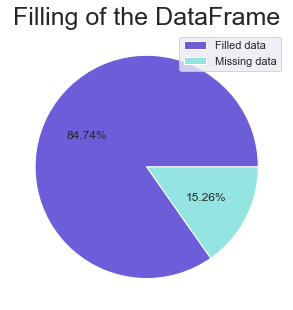

In [32]:
filling_rate(df_2015)

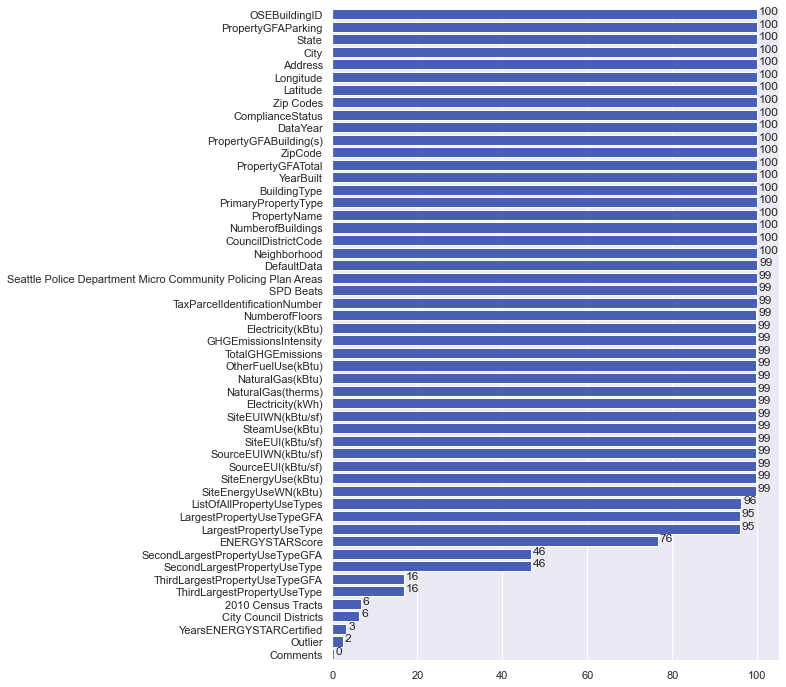

In [33]:
display_filling_of_col(df_2015, show_values=True, figsize=(8, 12))

### 3.b 2016

The global filling rate of the Dataframe is : 87.15%


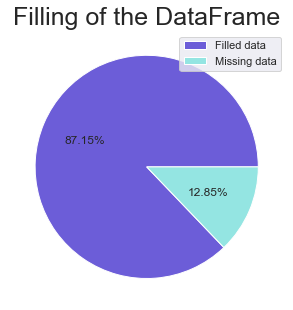

In [34]:
filling_rate(df_2016)

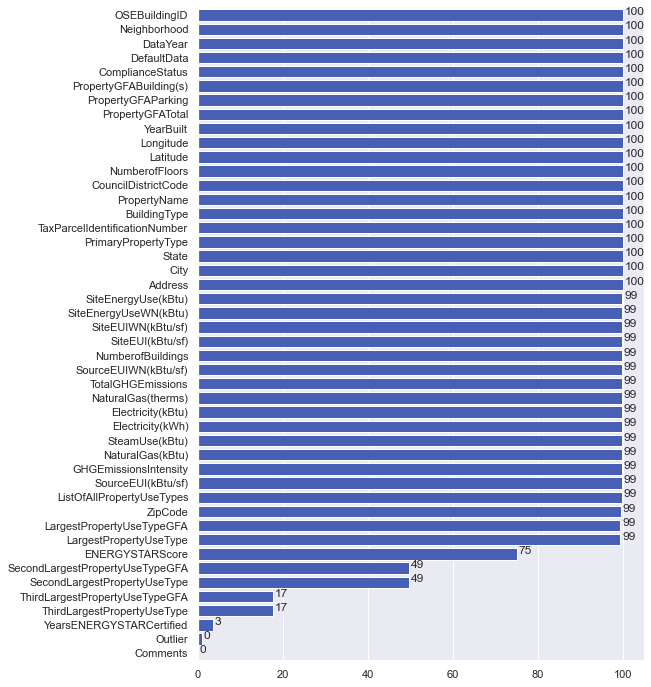

In [35]:
display_filling_of_col(df_2016, show_values=True, figsize=(8, 12))

## 4. EXPLICATIONS DES VARIABLES

In [99]:
inter, only_2015, only_2016

({'BuildingType',
  'ComplianceStatus',
  'CouncilDistrictCode',
  'DataYear',
  'DefaultData',
  'ENERGYSTARScore',
  'Electricity(kBtu)',
  'Electricity(kWh)',
  'LargestPropertyUseType',
  'LargestPropertyUseTypeGFA',
  'ListOfAllPropertyUseTypes',
  'NaturalGas(kBtu)',
  'NaturalGas(therms)',
  'Neighborhood',
  'NumberofBuildings',
  'NumberofFloors',
  'OSEBuildingID',
  'Outlier',
  'PrimaryPropertyType',
  'PropertyGFABuilding(s)',
  'PropertyGFAParking',
  'PropertyGFATotal',
  'PropertyName',
  'SecondLargestPropertyUseType',
  'SecondLargestPropertyUseTypeGFA',
  'SiteEUI(kBtu/sf)',
  'SiteEUIWN(kBtu/sf)',
  'SiteEnergyUse(kBtu)',
  'SiteEnergyUseWN(kBtu)',
  'SourceEUI(kBtu/sf)',
  'SourceEUIWN(kBtu/sf)',
  'SteamUse(kBtu)',
  'TaxParcelIdentificationNumber',
  'ThirdLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt',
  'YearsENERGYSTARCertified'},
 {'2010 Census Tracts',
  'City Council Districts',
  'Comment',
  'GHGEmissions(MetricTonsCO2e)',
  'G

**1. ENERGYSTARScore :  
Note de 1 à 100 qui évalue la performance énergétique globale d'une propriété. Un score de 50 représente la médiane nationale.**

In [32]:
meta_col_2015[meta_col_2015['name'] == 'ENERGYSTARScore']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
23,350402322,ENERGYSTARScore,number,"An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.",energystarscore,28,number,46302845,280.0,"{'largest': '100.00', 'non_null': 2560, 'average': '67.894140625', 'null': '780', 'top': [{'item': '100.00', 'count': '106'}, {'item': '95.00', 'count': '79'}, {'item': '94.00', 'count': '70'}, {'item': '97.00', 'count': '60'}, {'item': '99', 'count': '59'}, {'item': '93.00', 'count': '56'}, {'item': '81.00', 'count': '56'}, {'item': '98.00', 'count': '54'}, {'item': '89.00', 'count': '54'}, {'item': '86.00', 'count': '52'}, {'item': '85.00', 'count': '52'}, {'item': '91.00', 'count': '51'}, {'item': '92.00', 'count': '50'}, {'item': '88.00', 'count': '49'}, {'item': '83', 'count': '48'}, {'item': '84.00', 'count': '46'}, {'item': '77.00', 'count': '44'}, {'item': '90.00', 'count': '44'}, {'item': '79.00', 'count': '43'}, {'item': '1', 'count': '42'}], 'smallest': '1.00', 'not_null': '2560', 'sum': '173809.00', 'cardinality': '100'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**2. Electricity(kBtu) :  
La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée au réseau et produite par des systèmes renouvelables sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).**

In [35]:
meta_col_2015[meta_col_2015['name'] == 'Electricity(kBtu)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
32,350402331,Electricity(kBtu),number,"\t\nThe annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).",electricity_kbtu,37,number,46302854,304.0,"{'largest': '284726322', 'non_null': 3330, 'average': '3473209.381081081', 'null': '10', 'top': [{'item': '0', 'count': '2'}, {'item': '6581', 'count': '1'}, {'item': '497152', 'count': '1'}, {'item': '11442', 'count': '1'}, {'item': '17150', 'count': '1'}, {'item': '24127', 'count': '1'}, {'item': '329910', 'count': '1'}, {'item': '39033', 'count': '1'}, {'item': '42652', 'count': '1'}, {'item': '43945', 'count': '1'}, {'item': '50897', 'count': '1'}, {'item': '53404', 'count': '1'}, {'item': '64880', 'count': '1'}, {'item': '68982', 'count': '1'}, {'item': '228142', 'count': '1'}, {'item': '74704', 'count': '1'}, {'item': '75200', 'count': '1'}, {'item': '75306', 'count': '1'}, {'item': '76078', 'count': '1'}, {'item': '84073', 'count': '1'}], 'smallest': '0', 'not_null': '3330', 'sum': '11565787239', 'cardinality': '3329'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**3. Electricity(kWh):  
Electricity(kBtu) en kWh.**

In [ ]:
meta_col_2015[meta_col_2015['name'] == 'Electricity(kWh)']

**4. NaturalGas(therms) :
La quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en thermes.**

In [33]:
meta_col_2015[meta_col_2015['name'] == 'NaturalGas(therms)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
33,350402332,NaturalGas(therms),number,"The annual amount of utility-supplied natural gas consumed by the property, measured in therms.",naturalgas_therms,38,number,46302855,316.0,"{'largest': '1364484', 'non_null': 3330, 'average': '12533.04474474474', 'null': '10', 'top': [{'item': '0', 'count': '1256'}, {'item': '7584', 'count': '3'}, {'item': '2', 'count': '3'}, {'item': '10', 'count': '3'}, {'item': '4789', 'count': '3'}, {'item': '865', 'count': '2'}, {'item': '8856', 'count': '2'}, {'item': '12923', 'count': '2'}, {'item': '3019', 'count': '2'}, {'item': '7426', 'count': '2'}, {'item': '3229', 'count': '2'}, {'item': '417', 'count': '2'}, {'item': '6819', 'count': '2'}, {'item': '6880', 'count': '2'}, {'item': '11794', 'count': '2'}, {'item': '5088', 'count': '2'}, {'item': '1092', 'count': '2'}, {'item': '3479', 'count': '2'}, {'item': '1', 'count': '2'}, {'item': '23334', 'count': '2'}], 'smallest': '0', 'not_null': '3330', 'sum': '41735039', 'cardinality': '1995'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**5. PropertyGFABuilding(s) :  
Surface totale au sol en pieds carrés entre les surfaces extérieures des murs d’enceinte d’un bâtiment. Cela comprend toutes les zones à l'intérieur du ou des bâtiments, telles que l'espace des locataires, les espaces communs, les cages d'escalier, les sous-sols, le stockage, etc.**

In [34]:
meta_col_2015[meta_col_2015['name'] == 'PropertyGFABuilding(s)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
14,350402313,PropertyGFABuilding(s),number,"Total floor space in square feet between the outside surfaces of a building’s enclosing walls. This includes all areas inside the building(s), such as tenant space, common areas, stairwells, basements, storage, etc.",propertygfabuilding_s,19,number,46302836,364.0,"{'largest': '2200000', 'non_null': 3340, 'average': '79718.86047904192', 'null': '0', 'top': [{'item': '21600', 'count': '9'}, {'item': '25920', 'count': '8'}, {'item': '36000', 'count': '7'}, {'item': '28800', 'count': '7'}, {'item': '24000', 'count': '6'}, {'item': '30720', 'count': '4'}, {'item': '22320', 'count': '4'}, {'item': '23100', 'count': '3'}, {'item': '21200', 'count': '3'}, {'item': '22344', 'count': '3'}, {'item': '25200', 'count': '3'}, {'item': '30000', 'count': '3'}, {'item': '24288', 'count': '3'}, {'item': '33300', 'count': '3'}, {'item': '21900', 'count': '3'}, {'item': '30240', 'count': '3'}, {'item': '20000', 'count': '3'}, {'item': '25800', 'count': '3'}, {'item': '24100', 'count': '2'}, {'item': '40800', 'count': '2'}], 'smallest': '-50550', 'not_null': '3340', 'sum': '266260994', 'cardinality': '3145'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**6. PropertyGFAParking :  
Espace total en pieds carrés de tous les types de stationnement (entièrement clos, partiellement clos et ouvert).**

In [35]:
meta_col_2015[meta_col_2015['name'] == 'PropertyGFAParking']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
13,350402312,PropertyGFAParking,number,"Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open).",propertygfaparking,18,number,46302835,316.0,"{'largest': '512608', 'non_null': 3340, 'average': '11054.03233532934', 'null': '0', 'top': [{'item': '0', 'count': '2416'}, {'item': '25920', 'count': '3'}, {'item': '13320', 'count': '3'}, {'item': '12960', 'count': '2'}, {'item': '10800', 'count': '2'}, {'item': '6034', 'count': '2'}, {'item': '20416', 'count': '2'}, {'item': '30000', 'count': '2'}, {'item': '25800', 'count': '2'}, {'item': '22000', 'count': '2'}, {'item': '11544', 'count': '2'}, {'item': '100176', 'count': '2'}, {'item': '3000', 'count': '2'}, {'item': '24000', 'count': '2'}, {'item': '12044', 'count': '2'}, {'item': '6300', 'count': '2'}, {'item': '1496', 'count': '1'}, {'item': '1559', 'count': '1'}, {'item': '1730', 'count': '1'}, {'item': '1774', 'count': '1'}], 'smallest': '-3', 'not_null': '3340', 'sum': '36920468', 'cardinality': '908'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**7. SiteEUI(kBtu/sf) :  
L'intensité énergétique du site (IUE) est la consommation énergétique du site d'un établissement divisée par sa surface de plancher brute. La consommation d'énergie du site est la quantité annuelle de toute l'énergie consommée par la propriété sur place, comme indiqué sur les factures de services publics. L'IUE du site est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré.**

In [36]:
meta_col_2015[meta_col_2015['name'] == 'SiteEUI(kBtu/sf)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
24,350402323,SiteEUI(kBtu/sf),number,"Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot.",siteeui_kbtu_sf,29,number,46302846,292.0,"{'largest': '800.60', 'non_null': 3330, 'average': '53.62612612612613', 'null': '10', 'top': [{'item': '27.20', 'count': '18'}, {'item': '28.50', 'count': '16'}, {'item': '29.30', 'count': '16'}, {'item': '29.60', 'count': '16'}, {'item': '24.70', 'count': '15'}, {'item': '29.80', 'count': '15'}, {'item': '27.90', 'count': '15'}, {'item': '30.40', 'count': '14'}, {'item': '28.90', 'count': '14'}, {'item': '27.80', 'count': '13'}, {'item': '26.80', 'count': '13'}, {'item': '26.30', 'count': '13'}, {'item': '31.40', 'count': '12'}, {'item': '27.00', 'count': '12'}, {'item': '31.00', 'count': '12'}, {'item': '37.30', 'count': '12'}, {'item': '32.40', 'count': '12'}, {'item': '26.00', 'count': '12'}, {'item': '25.30', 'count': '12'}, {'item': '25.10', 'count': '12'}], 'smallest': '0.00', 'not_null': '3330', 'sum': '178575.00', 'cardinality': '1072'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**8. SiteEUIWN(kBtu/sf) :  
L'intensité d'utilisation de l'énergie du site normalisée selon les conditions météorologiques (WN) correspond à l'énergie du site WN d'une propriété divisée par sa surface de plancher brute (en pieds carrés). L'énergie du site WN est la consommation d'énergie du site que la propriété aurait consommée pendant 30 ans dans des conditions météorologiques moyennes. WN Site EUI est mesuré en mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré.**

In [37]:
meta_col_2015[meta_col_2015['name'] == 'SiteEUIWN(kBtu/sf)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
25,350402324,SiteEUIWN(kBtu/sf),number,\t\nWeather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.,siteeuiwn_kbtu_sf,30,number,46302847,316.0,"{'largest': '800.60', 'non_null': 3330, 'average': '57.58654654654655', 'null': '10', 'top': [{'item': '29.60', 'count': '15'}, {'item': '29.70', 'count': '15'}, {'item': '25.00', 'count': '14'}, {'item': '32.30', 'count': '14'}, {'item': '26.50', 'count': '14'}, {'item': '29.80', 'count': '14'}, {'item': '30.50', 'count': '14'}, {'item': '30.60', 'count': '13'}, {'item': '35.90', 'count': '13'}, {'item': '29.30', 'count': '13'}, {'item': '32.70', 'count': '13'}, {'item': '28.30', 'count': '12'}, {'item': '39.30', 'count': '12'}, {'item': '33.00', 'count': '12'}, {'item': '31.40', 'count': '12'}, {'item': '30.40', 'count': '12'}, {'item': '29.00', 'count': '12'}, {'item': '0.00', 'count': '12'}, {'item': '27.20', 'count': '12'}, {'item': '26.00', 'count': '12'}], 'smallest': '0.00', 'not_null': '3330', 'sum': '191763.20', 'cardinality': '1115'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**9. SiteEnergyUse(kBtu) :  
La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie.**

In [38]:
meta_col_2015[meta_col_2015['name'] == 'SiteEnergyUse(kBtu)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
28,350402327,SiteEnergyUse(kBtu),number,\t\nThe annual amount of energy consumed by the property from all sources of energy.,siteenergyuse_kbtu,33,number,46302850,328.0,"{'largest': '295812640', 'non_null': 3330, 'average': '4983106.046246246', 'null': '10', 'top': [{'item': '0', 'count': '2'}, {'item': '2074152', 'count': '2'}, {'item': '767213', 'count': '2'}, {'item': '784584', 'count': '2'}, {'item': '53401', 'count': '1'}, {'item': '56493', 'count': '1'}, {'item': '17150', 'count': '1'}, {'item': '93802', 'count': '1'}, {'item': '43943', 'count': '1'}, {'item': '93851', 'count': '1'}, {'item': '94186', 'count': '1'}, {'item': '95544', 'count': '1'}, {'item': '108795', 'count': '1'}, {'item': '109014', 'count': '1'}, {'item': '131810', 'count': '1'}, {'item': '91996', 'count': '1'}, {'item': '194839', 'count': '1'}, {'item': '132105', 'count': '1'}, {'item': '133880', 'count': '1'}, {'item': '142873', 'count': '1'}], 'smallest': '0', 'not_null': '3330', 'sum': '16593743134', 'cardinality': '3326'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**10. SourceEUI(kBtu/sf) :  
L'intensité d'utilisation de l'énergie à la source (IUE) est la consommation d'énergie à la source d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie à la source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes liées à la production, au transport et à la distribution. La source EUI est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré.**

In [39]:
meta_col_2015[meta_col_2015['name'] == 'SourceEUI(kBtu/sf)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
26,350402325,SourceEUI(kBtu/sf),number,"Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.",sourceeui_kbtu_sf,31,number,46302848,316.0,"{'largest': '2511.10', 'non_null': 3330, 'average': '132.7797297297297', 'null': '10', 'top': [{'item': '65.70', 'count': '9'}, {'item': '81.30', 'count': '9'}, {'item': '78.40', 'count': '9'}, {'item': '68.40', 'count': '9'}, {'item': '78.60', 'count': '9'}, {'item': '74.70', 'count': '8'}, {'item': '100.10', 'count': '8'}, {'item': '83.60', 'count': '8'}, {'item': '81.40', 'count': '8'}, {'item': '93.00', 'count': '8'}, {'item': '75.20', 'count': '8'}, {'item': '69.40', 'count': '8'}, {'item': '69.50', 'count': '7'}, {'item': '105.20', 'count': '7'}, {'item': '85.60', 'count': '7'}, {'item': '79.10', 'count': '7'}, {'item': '85.40', 'count': '7'}, {'item': '94.10', 'count': '7'}, {'item': '66.60', 'count': '7'}, {'item': '84.70', 'count': '7'}], 'smallest': '-2.00', 'not_null': '3330', 'sum': '442156.50', 'cardinality': '1673'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**11. SteamUse(kBtu) :  
La quantité annuelle de vapeur consommée par la propriété sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).**

In [40]:
meta_col_2015[meta_col_2015['name'] == 'SteamUse(kBtu)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
30,350402329,SteamUse(kBtu),number,"The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).",steamuse_kbtu,35,number,46302852,268.0,"{'largest': '127869744', 'non_null': 3330, 'average': '250285.0759759760', 'null': '10', 'top': [{'item': '0', 'count': '3200'}, {'item': '14089', 'count': '1'}, {'item': '138504', 'count': '1'}, {'item': '162514', 'count': '1'}, {'item': '184557', 'count': '1'}, {'item': '208000', 'count': '1'}, {'item': '216792', 'count': '1'}, {'item': '232000', 'count': '1'}, {'item': '296619', 'count': '1'}, {'item': '305664', 'count': '1'}, {'item': '310440', 'count': '1'}, {'item': '312366', 'count': '1'}, {'item': '368153', 'count': '1'}, {'item': '372528', 'count': '1'}, {'item': '383274', 'count': '1'}, {'item': '448146', 'count': '1'}, {'item': '456687', 'count': '1'}, {'item': '486182', 'count': '1'}, {'item': '505677', 'count': '1'}, {'item': '509178', 'count': '1'}], 'smallest': '0', 'not_null': '3330', 'sum': '833449303', 'cardinality': '131'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**12 . (2015) GHGEmissions(MetricTonsCO2e) // (2016) TotalGHGEmissions :  
La quantité totale d'émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et les gaz d'oxyde nitreux rejetés dans l'atmosphère à la suite de la consommation d'énergie de la propriété, mesurée en tonnes métriques d'équivalent dioxyde de carbone. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle CIty Light. Cela utilise le facteur d'émissions 2015 de Seattle City Light de 52,44 lbs CO2e / MWh. Facteur de vapeur Enwave = 170,17 lb CO2e / MMBtu. Facteur gaz provenant de l'EPA Portfolio Manager = 53,11 kg CO2e / MBtu.**

In [41]:
meta_col_2015[meta_col_2015['name'] == 'GHGEmissions(MetricTonsCO2e)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
36,350402335,GHGEmissions(MetricTonsCO2e),number,"The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.",ghgemissions_metrictonsco2e,41,number,46302858,436.0,"{'largest': '11824.89', 'non_null': 3330, 'average': '110.0941021021021', 'null': '10', 'top': [{'item': '4.65', 'count': '8'}, {'item': '3.47', 'count': '6'}, {'item': '3.54', 'count': '6'}, {'item': '4.55', 'count': '6'}, {'item': '6.71', 'count': '5'}, {'item': '4.73', 'count': '5'}, {'item': '4.26', 'count': '5'}, {'item': '3.62', 'count': '5'}, {'item': '5.87', 'count': '5'}, {'item': '3.98', 'count': '4'}, {'item': '4.44', 'count': '4'}, {'item': '6.19', 'count': '4'}, {'item': '4.32', 'count': '4'}, {'item': '9.83', 'count': '4'}, {'item': '11.82', 'count': '4'}, {'item': '3.34', 'count': '4'}, {'item': '4.86', 'count': '4'}, {'item': '5.35', 'count': '4'}, {'item': '4.25', 'count': '4'}, {'item': '4.03', 'count': '4'}], 'smallest': '0', 'not_null': '3330', 'sum': '366613.36', 'cardinality': '2763'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


**13. (2015) GHGEmissionsIntensity(kgCO2e/ft2) // (2016) GHGEmissionsIntensity:  
Émissions totales de gaz à effet de serre divisées par la superficie de plancher brute de la propriété, mesurées en kilogrammes d'équivalent dioxyde de carbone par pied carré. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources génératrices de Seattle City Light**

In [42]:
meta_col_2015[meta_col_2015['name'] == 'GHGEmissionsIntensity(kgCO2e/ft2)']

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
37,350402336,GHGEmissionsIntensity(kgCO2e/ft2),number,"\t\nTotal Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources",ghgemissionsintensity_kgco2e_ft2,42,number,46302859,496.0,"{'largest': '31.38', 'non_null': 3330, 'average': '0.9853393393393393', 'null': '10', 'top': [{'item': '0.06', 'count': '258'}, {'item': '0.07', 'count': '206'}, {'item': '0.05', 'count': '154'}, {'item': '0.08', 'count': '146'}, {'item': '0.09', 'count': '81'}, {'item': '0.10', 'count': '71'}, {'item': '0.11', 'count': '51'}, {'item': '0.04', 'count': '46'}, {'item': '0.12', 'count': '42'}, {'item': '0.14', 'count': '35'}, {'item': '0.13', 'count': '32'}, {'item': '0.03', 'count': '31'}, {'item': '0.17', 'count': '28'}, {'item': '0.02', 'count': '27'}, {'item': '0.24', 'count': '24'}, {'item': '0.56', 'count': '23'}, {'item': '0.18', 'count': '23'}, {'item': '0.15', 'count': '21'}, {'item': '0.48', 'count': '20'}, {'item': '0.55', 'count': '20'}], 'smallest': '0.00', 'not_null': '3330', 'sum': '3281.18', 'cardinality': '471'}","{'precisionStyle': 'standard', 'noCommas': 'false', 'align': 'right'}",NaN


## 5. DOUBLONS?

In [36]:
print(f"Il y a {df_2015.shape[0] - df_2015.drop_duplicates('OSEBuildingID', keep='first').shape[0]} doublons.")

Il y a 0 doublons.


In [37]:
print(f"Il y a {df_2016.shape[0] - df_2016.drop_duplicates('OSEBuildingID', keep='first').shape[0]} doublons.")

Il y a 0 doublons.


## 6. ANALYSE UNIVARIÉE

In [38]:
df_2015[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']].describe()

,SiteEnergyUse(kBtu),TotalGHGEmissions
count,3.330000e+03,3330.000000
mean,4.983106e+06,110.094102
std,1.375330e+07,409.450179
min,0.000000e+00,0.000000
25%,9.139300e+05,9.265000
50%,1.776219e+06,32.740000
75%,4.044277e+06,88.642500
max,2.958126e+08,11824.890000


In [39]:
df_2016[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']].describe()

,SiteEnergyUse(kBtu),TotalGHGEmissions
count,3.371000e+03,3367.000000
mean,5.403667e+06,119.723971
std,2.161063e+07,538.832227
min,0.000000e+00,-0.800000
25%,9.251286e+05,9.495000
50%,1.803753e+06,33.920000
75%,4.222455e+06,93.940000
max,8.739237e+08,16870.980000


### 6.a SiteEnergyUse(kBtu) initiale

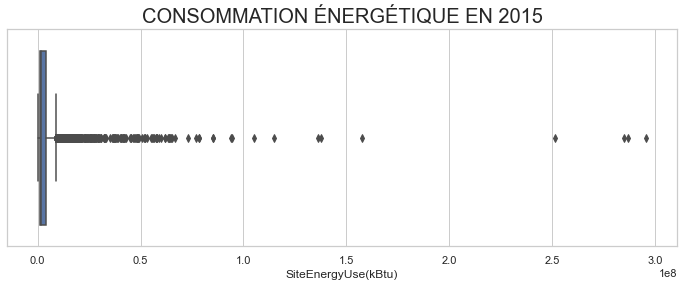

In [40]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=df_2015['SiteEnergyUse(kBtu)'])
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2015', fontsize=20);

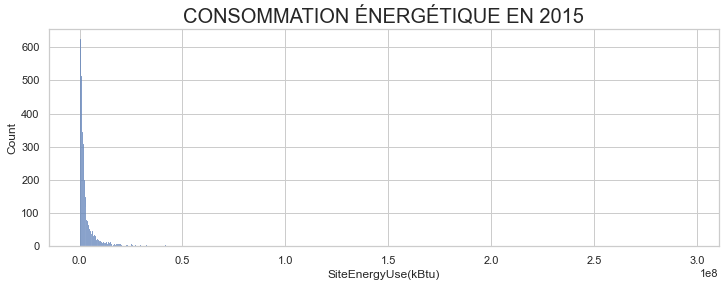

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2015, x='SiteEnergyUse(kBtu)')
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2015', fontsize=20);

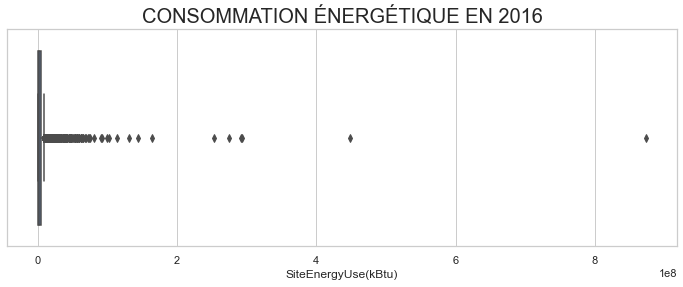

In [42]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=df_2016['SiteEnergyUse(kBtu)'])
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2016', fontsize=20);

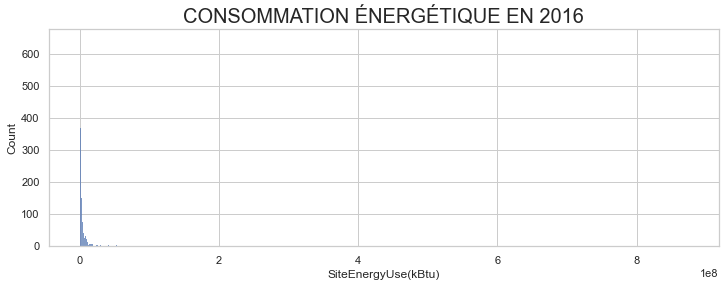

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2016, x='SiteEnergyUse(kBtu)')
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2016', fontsize=20);

### Transformation logarithmique

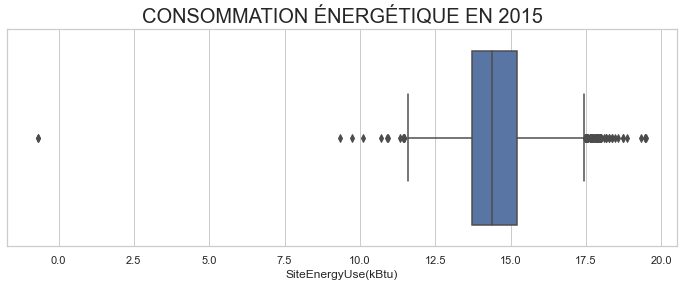

In [44]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=np.log(df_2015['SiteEnergyUse(kBtu)'] + 0.5))
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2015', fontsize=20);

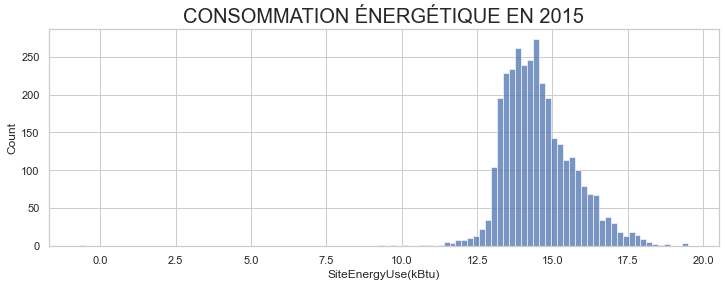

In [45]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2015, x=np.log(df_2015['SiteEnergyUse(kBtu)'] + 0.5))
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2015', fontsize=20);

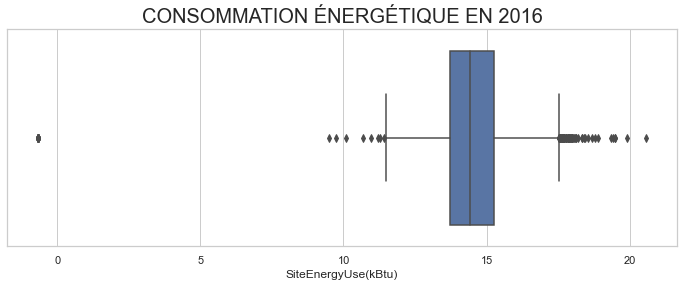

In [46]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=np.log(df_2016['SiteEnergyUse(kBtu)'] + 0.5))
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2016', fontsize=20);

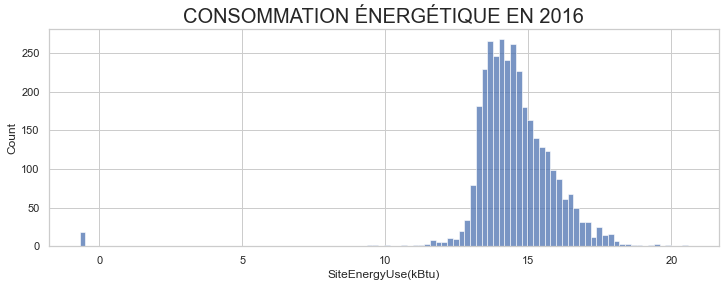

In [47]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2016, x=np.log(df_2016['SiteEnergyUse(kBtu)'] + 0.5))
plt.title('CONSOMMATION ÉNERGÉTIQUE EN 2016', fontsize=20);

### Test de normalité (Shapiro-Wilk)  
    H0 : La distribtuion de SiteEnergyUse(kBtu) est normal.  
    H1 : La ditribution de SiteEnergyUse(kBtu) n'est pas normal

In [48]:
def shapiro_wilk(dataframe, feature):
    '''This function proceed to the Shapiro-Wilk test (for gaussian distribution).
    It takes a dataframe and the name of the feature to test.
    It filters for non-null vallues of the feature and print the results.'''
    
    # filtering non-null data for the feature
    mask = dataframe[feature].notnull()
    data_view = dataframe[mask][feature]

    # processing the Shopiro-Wilk test on the filtered data
    results = shapiro(data_view)

    # Print results
    print("Shapiro-Wilk test's statistic value is: W = {}".format(results[0]))
    print("Shapiro-Wilk test's p-value is: p = {}".format(results[1]))
    print("\nGaussian distribution hypothesis for \'{}\' can be rejected at a risk of {:.2f}%.".format(feature, results[1]*100))

In [49]:
shapiro_wilk(df_2015, 'SiteEnergyUse(kBtu)')

Shapiro-Wilk test's statistic value is: W = 0.2760465145111084
Shapiro-Wilk test's p-value is: p = 0.0

Gaussian distribution hypothesis for 'SiteEnergyUse(kBtu)' can be rejected at a risk of 0.00%.


In [50]:
shapiro_wilk(df_2016, 'SiteEnergyUse(kBtu)')

Shapiro-Wilk test's statistic value is: W = 0.15326350927352905
Shapiro-Wilk test's p-value is: p = 0.0

Gaussian distribution hypothesis for 'SiteEnergyUse(kBtu)' can be rejected at a risk of 0.00%.


### 6.b TotalGHGEmissions

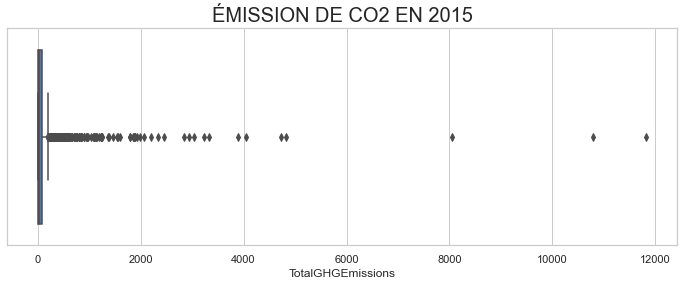

In [51]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=df_2015['TotalGHGEmissions'])
plt.title('ÉMISSION DE CO2 EN 2015', fontsize=20);

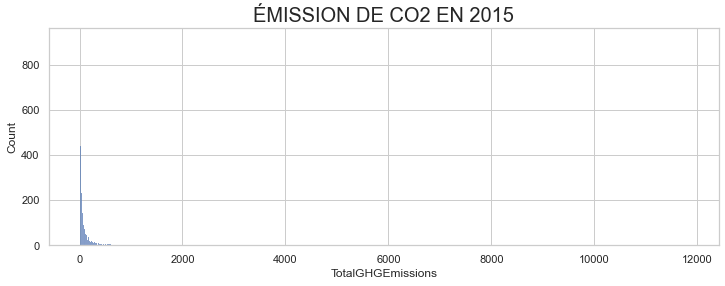

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2015, x='TotalGHGEmissions')
plt.title('ÉMISSION DE CO2 EN 2015', fontsize=20);

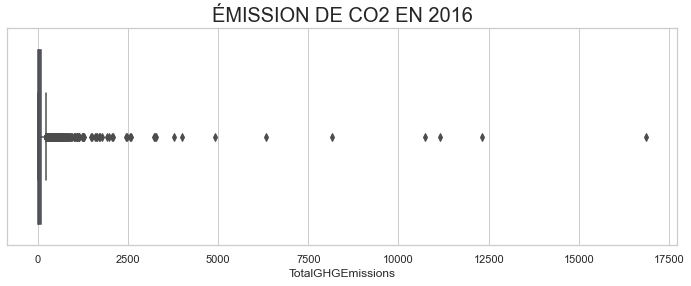

In [53]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=df_2016['TotalGHGEmissions'])
plt.title('ÉMISSION DE CO2 EN 2016', fontsize=20);

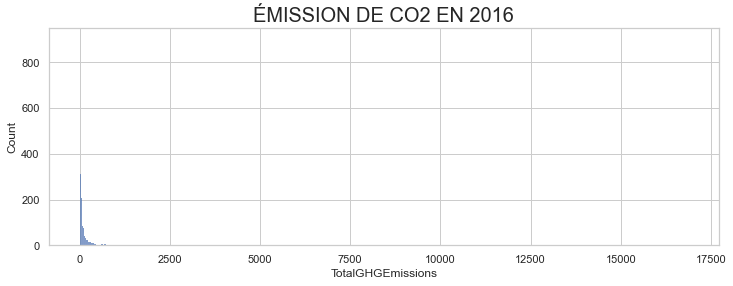

In [54]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2016, x='TotalGHGEmissions')
plt.title('ÉMISSION DE CO2 EN 2016', fontsize=20);

### Transformation logarithmique

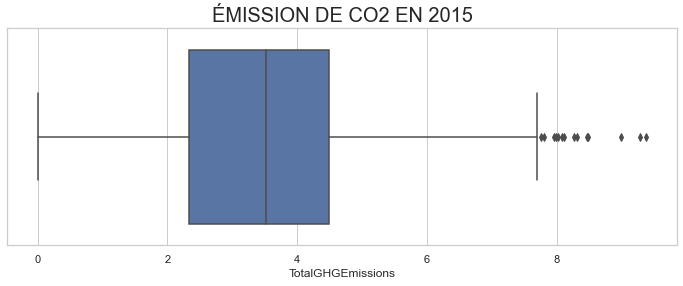

In [55]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=np.log(df_2015['TotalGHGEmissions'] + 1))
plt.title('ÉMISSION DE CO2 EN 2015', fontsize=20);

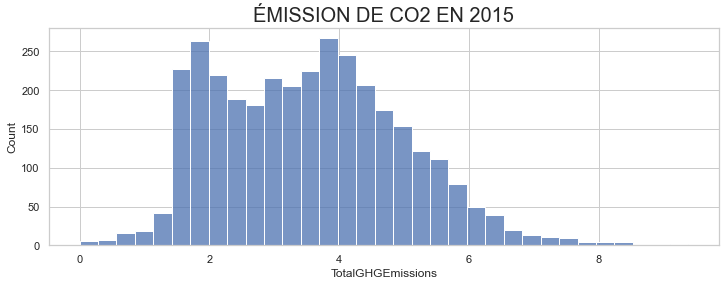

In [56]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2015, x=np.log(df_2015['TotalGHGEmissions'] + 1))
plt.title('ÉMISSION DE CO2 EN 2015', fontsize=20);

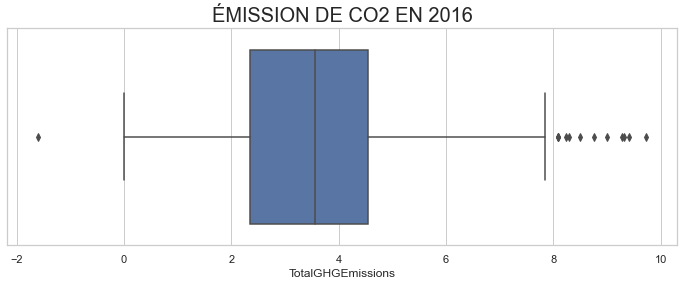

In [57]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(x=np.log(df_2016['TotalGHGEmissions'] + 1))
plt.title('ÉMISSION DE CO2 EN 2016', fontsize=20);

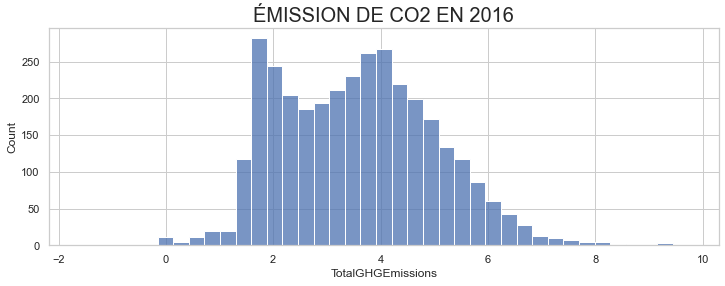

In [58]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.histplot(df_2016, x=np.log(df_2016['TotalGHGEmissions'] + 1))
plt.title('ÉMISSION DE CO2 EN 2016', fontsize=20);

### Test de normalité (Shapiro-Wilk)  
    H0 : La distribtuion de SiteEnergyUse(kBtu) est normal.  
    H1 : La ditribution de SiteEnergyUse(kBtu) n'est pas normal

In [59]:
shapiro_wilk(df_2015, 'TotalGHGEmissions')

Shapiro-Wilk test's statistic value is: W = 0.19610530138015747
Shapiro-Wilk test's p-value is: p = 0.0

Gaussian distribution hypothesis for 'TotalGHGEmissions' can be rejected at a risk of 0.00%.


In [60]:
shapiro_wilk(df_2016, 'TotalGHGEmissions')

Shapiro-Wilk test's statistic value is: W = 0.14604246616363525
Shapiro-Wilk test's p-value is: p = 0.0

Gaussian distribution hypothesis for 'TotalGHGEmissions' can be rejected at a risk of 0.00%.


## 7. SÉLECTION DES FEATURES

In [61]:
features_selected = {'TotalGHGEmissions'
                    ,'SiteEnergyUse(kBtu)'
                    ,'BuildingType'
                    ,'ComplianceStatus' # état de conformité
                    ,'CouncilDistrictCode' # Propriété District municipal de la ville de Seattle
                    #,'DataYear' #?
                    #,'DefaultData'
                    #,'LargestPropertyUseType' # type de batiment --> primaryPropertyType
                    #,'LargestPropertyUseTypeGFA' #?  --> primaryPropertyType
                    ,'ListOfAllPropertyUseTypes' # all types
                    ,'Neighborhood' # qurtier
                    ,'NumberofBuildings'
                    ,'NumberofFloors'
                    #,'Outlier'
                    ,'PrimaryPropertyType'
                    ,'PropertyGFABuilding(s)' #surface brute intérieure
                    ,'PropertyGFAParking'
                    ,'PropertyGFATotal'
                    ,'YearBuilt'
                    ,'Latitude'
                    ,'Longitude'
                    ,'OSEBuildingID'} 

### 7.a Comparaison 2015 - 1016

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'EMISSION DE CO2 EN 2015 ET 2016')

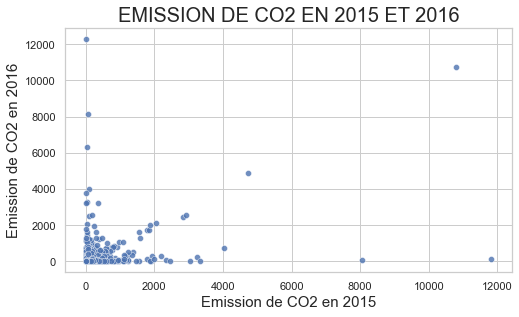

In [62]:
fig, ax = plt.subplots(figsize=(8, 4.5))

sns.scatterplot(df_2015.loc[df_2015['OSEBuildingID'].map(lambda x: x in ID_inter), 'TotalGHGEmissions']
               ,df_2016.loc[df_2016['OSEBuildingID'].map(lambda x: x in ID_inter), 'TotalGHGEmissions']
               ,alpha=0.8)

ax.set_xlabel('Emission de CO2 en 2015', fontsize=15)
ax.set_ylabel('Emission de CO2 en 2016', fontsize=15)
plt.title('EMISSION DE CO2 EN 2015 ET 2016', fontsize=20)

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, "CONSOMATION D'ÉNERGIE EN 2015 ET 2016")

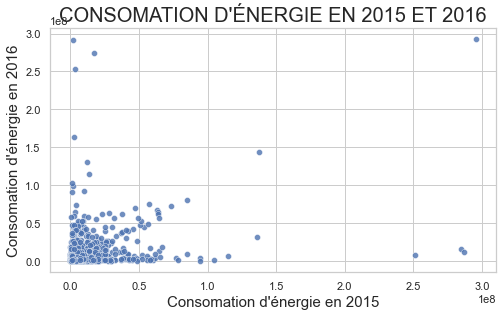

In [63]:
fig, ax = plt.subplots(figsize=(8, 4.5))

sns.scatterplot(df_2015.loc[df_2015['OSEBuildingID'].map(lambda x: x in ID_inter), 'SiteEnergyUse(kBtu)']
               ,df_2016.loc[df_2016['OSEBuildingID'].map(lambda x: x in ID_inter), 'SiteEnergyUse(kBtu)']
               ,alpha=0.8)

ax.set_xlabel('Consomation d\'énergie en 2015', fontsize=15)
ax.set_ylabel('Consomation d\'énergie en 2016', fontsize=15)
plt.title('CONSOMATION D\'ÉNERGIE EN 2015 ET 2016', fontsize=20)

In [64]:
df_2015.loc[df_2015['Outlier'].notnull() & df_2015['OSEBuildingID'].map(lambda x: x in ID_inter), 'SiteEnergyUse(kBtu)']

3       28229320.0
62             NaN
228     41092076.0
322     15324777.0
387       408513.0
           ...    
3255     1377184.0
3276     3141319.0
3284     9387211.0
3306     4777648.0
3326     7641887.0
Name: SiteEnergyUse(kBtu), Length: 81, dtype: float64

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, "CONSOMATION D'ÉNERGIE EN 2015 ET 2016")

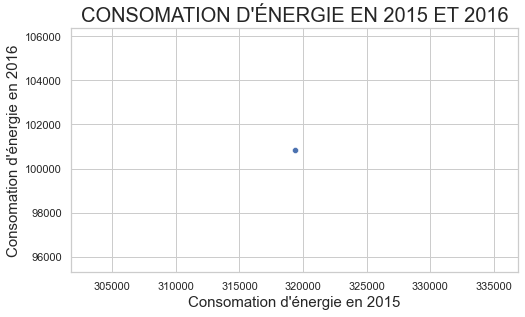

In [65]:
fig, ax = plt.subplots(figsize=(8, 4.5))

sns.scatterplot(df_2015.loc[df_2015['Outlier'].notnull() & df_2015['OSEBuildingID'].map(lambda x: x in ID_inter), 'SiteEnergyUse(kBtu)']
               ,df_2016.loc[df_2016['Outlier'].notnull() & df_2016['OSEBuildingID'].map(lambda x: x in ID_inter), 'SiteEnergyUse(kBtu)'])

ax.set_xlabel('Consomation d\'énergie en 2015', fontsize=15)
ax.set_ylabel('Consomation d\'énergie en 2016', fontsize=15)
plt.title('CONSOMATION D\'ÉNERGIE EN 2015 ET 2016', fontsize=20)

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, "CONSOMATION D'ÉNERGIE EN 2015 ET 2016")

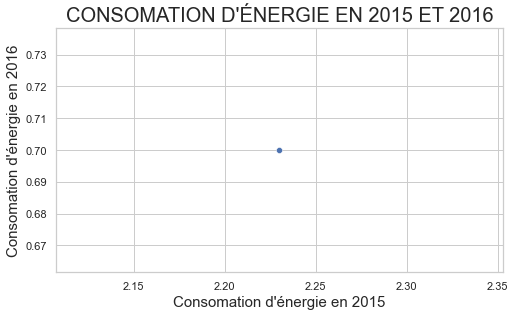

In [66]:
fig, ax = plt.subplots(figsize=(8, 4.5))

sns.scatterplot(df_2015.loc[df_2015['Outlier'].notnull() & df_2015['OSEBuildingID'].map(lambda x: x in ID_inter), 'TotalGHGEmissions']
               ,df_2016.loc[df_2016['Outlier'].notnull() & df_2016['OSEBuildingID'].map(lambda x: x in ID_inter), 'TotalGHGEmissions'])

ax.set_xlabel('Consomation d\'énergie en 2015', fontsize=15)
ax.set_ylabel('Consomation d\'énergie en 2016', fontsize=15)
plt.title('CONSOMATION D\'ÉNERGIE EN 2015 ET 2016', fontsize=20)

### 7.b Nettoyage des features utiles

In [67]:
#Suppr Outlier
df_2015_clean = df_2015.loc[df_2015['Outlier'].isnull()]
df_2016_clean = df_2016.loc[df_2016['Outlier'].isnull()]

In [68]:
print(f"Lignes de départ 2015 : {df_2015.shape[0]}\n\
Lignes aupprimées 2015 : {df_2015.shape[0] - df_2015_clean.shape[0]}\n\
Lignes actuelles 2015 : {df_2015_clean.shape[0]}\n\n\
Lignes de départ 2016 : {df_2016.shape[0]}\n\
Lignes aupprimées 2016 : {df_2016.shape[0] - df_2016_clean.shape[0]}\n\
Lignes actuelles 2016 : {df_2016_clean.shape[0]}\n")

Lignes de départ 2015 : 3340
Lignes aupprimées 2015 : 84
Lignes actuelles 2015 : 3256

Lignes de départ 2016 : 3376
Lignes aupprimées 2016 : 32
Lignes actuelles 2016 : 3344



In [69]:
#On concatène nos 2 df.
df = pd.concat([df_2015_clean, df_2016_clean], axis=0, join='outer',ignore_index = True)
df.shape

(6600, 52)

In [70]:
#Reccupération des commentaires pour extraire de l'information sur les récentes rénovations
pd.options.display.max_colwidth = 600
Commentaire = df[['OSEBuildingID','DataYear','Comments']][df['Comments'].notna()]
Commentaire

,OSEBuildingID,DataYear,Comments
431,594,2015,"Part of McKinstry's campus, property operates a fabrication and production shop and is conditioned by natural gas overhead radiant unit heaters with no cooling. Learn more at www.mckinstry.com."
432,595,2015,One of two office buildings on McKinstry's campus partially remodeled in 2009 from warehouse to office space. Served by rooftop air handling units with underfloor VAVs. Self-performed energy efficiency upgrades in 2015 include a long-term LED lighting re
585,792,2015,"Part of McKinstry’s campus, this remodeled warehouse is mainly office but includes a full-size basketball court and gym with locker rooms, bistro with a full kitchen, and data center. Served by rooftop package units for heating and cooling. Upgrades inclu"
706,19694,2015,Construction completed in mid 2015. The building was unoccupied for most of 2015.
1326,21570,2015,Under construction starting 6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016. Year built changed from 1950 to 2016.
1340,21616,2015,Under construction starting 6/2015 (old building demolished) and ending 9/2017. New Building re-opens 9/2017. Year built changed from 1954 to 2017.
2060,24408,2015,Under construction starting 09/2014 (old building demolished) and ending 9/2017. New Buildings (two) re-open 9/2017. Year built changed from 1953 to 2017.
2182,24780,2015,"Part of McKinstry's campus, the office space for this building sites on the 3rd floor above a 2-story parking garage and is served by rooftop package units for both heating and cooling. Learn more at www.mckinstryinnovationcenter.com."
2270,25163,2015,"Part of McKinstry's campus, property includes a warehouse, a local pipe supplier, and a local insulation contractor. Learn more at www.mckinstry.com."
2331,25361,2015,Property now has two buildings: Thornton Creek Elementary School and the Decatur Building. New Thornton Creek Elementary built on Decatur Property and under construction from 6/2013 - 9/2016.


In [71]:
# Drop duplicate : On garde uniquement les données sur une année quand elles sont disponibles sur les deux années.
df.drop_duplicates(subset = ['OSEBuildingID'], keep = 'last', inplace = True)
df.shape[0]

3408

In [72]:
df_selected = df[features_selected]

In [73]:
# On Crée une variable où l'on notifie les bâtiments qui ont eu des travaux récents d'amélioriation de l'efficacité
df_selected['RecentUpgrade'] = 0
#On sélectionne les index des batiments avec des travaux récents d'amélioration et on leur attribue la valeur Yes
Reno = df_selected[(df_selected['OSEBuildingID'] == 595) | (df_selected['OSEBuildingID'] == 792) | (df_selected['OSEBuildingID'] == 26240)].index.values
df_selected.loc[Reno, 'RecentUpgrade'] = 1

<ipython-input-73-e177de13a038>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['RecentUpgrade'] = 0
C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [74]:
cate_var = ['RecentUpgrade']

In [75]:
df_selected['Neighborhood'].unique()

array(['DOWNTOWN', 'DELRIDGE', 'LAKE UNION', 'GREATER DUWAMISH', 'EAST',
       'NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'SOUTHEAST', 'BALLARD',
       'NORTH', 'SOUTHWEST', 'CENTRAL', 'NORTHEAST', 'Central', 'Ballard',
       'North', 'Delridge', 'Northwest', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

In [76]:
# On uniformise l'écriture pour ne pas avoir de doublons.
df_selected['Neighborhood'] = df_selected['Neighborhood'].str.capitalize()
Delridge = df_selected.index[df_selected['Neighborhood']== 'Delridge neighborhoods'].tolist()
df_selected.loc[Delridge, 'Neighborhood'] = 'Delridge'
df_selected['Neighborhood'].nunique()

<ipython-input-76-7e5cdb69e447>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Neighborhood'] = df_selected['Neighborhood'].str.capitalize()


13

In [77]:
cate_var.append('Neighborhood')

In [1]:
############################################################################################
# #
############################################################################################

In [79]:
df_selected.groupby('PrimaryPropertyType')['OSEBuildingID'].nunique()

PrimaryPropertyType
Distribution Center             53
High-Rise Multifamily          104
Hospital                        10
Hotel                           76
K-12 School                    141
Laboratory                      10
Large Office                   173
Low-Rise Multifamily           997
Medical Office                  42
Mid-Rise Multifamily           566
Mixed Use Property             134
Non-Refrigerated Warehouse       3
Office                           3
Other                          263
Refrigerated Warehouse          12
Residence Hall                  23
Restaurant                      12
Restaurant\n                     1
Retail Store                    93
Self-Storage Facility           28
Senior Care Community           45
Small- and Mid-Sized Office    295
Supermarket / Grocery Store     40
University                      25
Warehouse                      187
Worship Facility                72
Name: OSEBuildingID, dtype: int64

In [80]:
# On réduit le nombre de primary property type pour augmenter l'efficacité des algo de prédiction.
print(" nombre avant transformation : " , df_selected['PrimaryPropertyType'].nunique()  )

Restau = df_selected.index[df_selected['PrimaryPropertyType']== 'Restaurant\n'].tolist()
df_selected.loc[Restau, 'PrimaryPropertyType'] = 'Restaurant'

Warehouse = df_selected.index[df_selected['PrimaryPropertyType']== 'Non-Refrigerated Warehouse'].tolist()
df_selected.loc[Warehouse, 'PrimaryPropertyType'] = 'Warehouse'

Office = df_selected.index[(df_selected['PrimaryPropertyType']== 'Large Office') | \
                  (df_selected['PrimaryPropertyType']== 'Small- and Mid-Sized Office') ].tolist()
df_selected.loc[Office, 'PrimaryPropertyType'] = 'Office'

print(" nombre après transformation : " ,df_selected['PrimaryPropertyType'].nunique())

 nombre avant transformation :  26
 nombre après transformation :  22


In [81]:
cate_var.append('PrimaryPropertyType')

In [82]:
###################################################################################################
# df_selected = df_selected.join(pd.get_dummies(df_selected.PrimaryPropertyType, drop_first=True))


In [83]:
df_selected['BuildingType'].unique()

array(['Multifamily LR (1-4)', 'NonResidential', 'SPS-District K-12',
       'Multifamily MR (5-9)', 'Nonresidential COS', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [84]:
cate_var.append('BuildingType')

In [85]:
###################################################################################################
# 

In [86]:
df_selected.shape

(3408, 18)

In [87]:
df_selected['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [88]:
df_selected.shape

(3408, 18)

In [89]:
df_selected[(df_selected['ComplianceStatus'] != 'Error - Correct Default Data') & (df_selected['ComplianceStatus'] != 'Missing Data')].shape

(3282, 18)

In [90]:
df_selected = df_selected[(df_selected['ComplianceStatus'] != 'Error - Correct Default Data') & (df_selected['ComplianceStatus'] != 'Missing Data')]

In [91]:
df_selected.loc[df_selected['ComplianceStatus'] == "Compliant", 'ComplianceStatus'] = 1
df_selected.loc[df_selected['ComplianceStatus'] == "Non-Compliant", 'ComplianceStatus'] = 0

In [92]:
df_selected = df_selected[df_selected['ComplianceStatus'] == 1]

In [93]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3275 entries, 46 to 6599
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Longitude                  3275 non-null   float64
 1   Neighborhood               3275 non-null   object 
 2   BuildingType               3275 non-null   object 
 3   TotalGHGEmissions          3270 non-null   float64
 4   ComplianceStatus           3275 non-null   object 
 5   PropertyGFAParking         3275 non-null   int64  
 6   CouncilDistrictCode        3275 non-null   int64  
 7   YearBuilt                  3275 non-null   int64  
 8   PropertyGFABuilding(s)     3275 non-null   int64  
 9   OSEBuildingID              3275 non-null   int64  
 10  SiteEnergyUse(kBtu)        3274 non-null   float64
 11  PropertyGFATotal           3275 non-null   int64  
 12  NumberofBuildings          3272 non-null   float64
 13  Latitude                   3275 non-null   floa

In [94]:
df_selected['CouncilDistrictCode'].unique()
# -> caté

array([7, 1, 2, 3, 5, 6, 4], dtype=int64)

In [95]:
cate_var.append('CouncilDistrictCode')

In [96]:
# df_selected['CouncilDistrictCode'] = df_selected['CouncilDistrictCode'].map(lambda x: "CSC " + str(x))
# df_selected = df_selected.join(pd.get_dummies(df_selected.CouncilDistrictCode, drop_first=True))

In [97]:
#df_selected['ListOfAllPropertyUseTypes'].unique() #no

In [98]:
df_selected['NumberofBuildings'].isnull().sum()

3

In [99]:
df_selected.dropna(subset=['NumberofBuildings'], axis=0, inplace=True)

In [100]:
df_selected['NumberofFloors'].isnull().sum()

1

In [101]:
df_selected.dropna(subset=['NumberofFloors'], axis=0, inplace=True)

In [102]:
df_selected['PropertyGFAParking'].describe()

count      3271.000000
mean       8519.965454
std       33777.239573
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      512608.000000
Name: PropertyGFAParking, dtype: float64

In [103]:
df_selected['PropertyGFATotal'].describe()

count    3.271000e+03
mean     9.544337e+04
std      2.213636e+05
min      1.128500e+04
25%      2.825800e+04
50%      4.376200e+04
75%      9.110950e+04
max      9.320156e+06
Name: PropertyGFATotal, dtype: float64

In [104]:
df_selected['YearBuilt']

46      1900
163     2007
202     1989
269     1906
309     1947
        ... 
6594    1982
6596    2004
6597    1974
6598    1989
6599    1938
Name: YearBuilt, Length: 3271, dtype: int64

In [105]:
df_selected['Age'] = 2016 - df_selected['YearBuilt']

In [106]:
df_selected.corr()['SiteEnergyUse(kBtu)'].sort_values(ascending=False)

SiteEnergyUse(kBtu)       1.000000
TotalGHGEmissions         0.865294
PropertyGFABuilding(s)    0.814770
PropertyGFATotal          0.801677
NumberofBuildings         0.690929
NumberofFloors            0.204471
PropertyGFAParking        0.192197
CouncilDistrictCode       0.039623
Longitude                 0.033177
YearBuilt                 0.030126
RecentUpgrade            -0.002083
Latitude                 -0.023346
Age                      -0.030126
OSEBuildingID            -0.116086
Name: SiteEnergyUse(kBtu), dtype: float64

skewed_value => squared, log, 1/x, boxcox
koalas, spark-sklearn, mlflow

In [107]:
df_selected.corr()['TotalGHGEmissions'].sort_values(ascending=False)

TotalGHGEmissions         1.000000
SiteEnergyUse(kBtu)       0.865294
PropertyGFABuilding(s)    0.546621
PropertyGFATotal          0.536449
NumberofBuildings         0.407253
NumberofFloors            0.135372
PropertyGFAParking        0.119844
Longitude                 0.035143
CouncilDistrictCode       0.017739
YearBuilt                 0.017012
RecentUpgrade            -0.001508
Age                      -0.017012
Latitude                 -0.028719
OSEBuildingID            -0.097167
Name: TotalGHGEmissions, dtype: float64

In [108]:
df_selected.columns

Index(['Longitude', 'Neighborhood', 'BuildingType', 'TotalGHGEmissions',
       'ComplianceStatus', 'PropertyGFAParking', 'CouncilDistrictCode',
       'YearBuilt', 'PropertyGFABuilding(s)', 'OSEBuildingID',
       'SiteEnergyUse(kBtu)', 'PropertyGFATotal', 'NumberofBuildings',
       'Latitude', 'NumberofFloors', 'PrimaryPropertyType',
       'ListOfAllPropertyUseTypes', 'RecentUpgrade', 'Age'],
      dtype='object')

In [109]:
df_selected.drop(columns='ListOfAllPropertyUseTypes', inplace=True)

In [110]:
df_selected.drop(columns='YearBuilt', inplace=True)

In [111]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3271 entries, 46 to 6599
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Longitude               3271 non-null   float64
 1   Neighborhood            3271 non-null   object 
 2   BuildingType            3271 non-null   object 
 3   TotalGHGEmissions       3269 non-null   float64
 4   ComplianceStatus        3271 non-null   object 
 5   PropertyGFAParking      3271 non-null   int64  
 6   CouncilDistrictCode     3271 non-null   int64  
 7   PropertyGFABuilding(s)  3271 non-null   int64  
 8   OSEBuildingID           3271 non-null   int64  
 9   SiteEnergyUse(kBtu)     3270 non-null   float64
 10  PropertyGFATotal        3271 non-null   int64  
 11  NumberofBuildings       3271 non-null   float64
 12  Latitude                3271 non-null   float64
 13  NumberofFloors          3271 non-null   float64
 14  PrimaryPropertyType     3271 non-null  

In [112]:
num_var = ['Longitude',
           'Latitude',
           'PropertyGFABuilding(s)',
           'NumberofBuildings',
           'NumberofFloors',
           'PropertyGFATotal',
           'PropertyGFAParking',
           'SiteEnergyUse(kBtu)',
           'TotalGHGEmissions',
           'Age']

In [113]:
cate_var

['RecentUpgrade',
 'Neighborhood',
 'PrimaryPropertyType',
 'BuildingType',
 'CouncilDistrictCode']

### ANOVA

In [114]:
df_selected = df_selected.loc[df_selected['TotalGHGEmissions'].notnull()]

In [115]:
df_selected = df_selected.loc[df_selected['SiteEnergyUse(kBtu)'].notnull()]

In [116]:
df_selected.shape

(3269, 17)

In [117]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [118]:
eta_squared(df_selected['Neighborhood'],
            df_selected['TotalGHGEmissions'])

0.0072423395026430535

In [119]:
def print_anova(var, target):
    print(f"Le rapport de corrélation entre {var.name} et {target.name} est : {eta_squared(var, target)}")

In [120]:
for cat in cate_var:
    print_anova(df_selected[cat], df_selected['TotalGHGEmissions'])

Le rapport de corrélation entre RecentUpgrade et TotalGHGEmissions est : 2.273590006128513e-06
Le rapport de corrélation entre Neighborhood et TotalGHGEmissions est : 0.0072423395026430535
Le rapport de corrélation entre PrimaryPropertyType et TotalGHGEmissions est : 0.2930122686908356
Le rapport de corrélation entre BuildingType et TotalGHGEmissions est : 0.1019313866640234
Le rapport de corrélation entre CouncilDistrictCode et TotalGHGEmissions est : 0.00482111788597277


In [121]:
for cat in cate_var:
    print_anova(df_selected[cat], df_selected['SiteEnergyUse(kBtu)'])

Le rapport de corrélation entre RecentUpgrade et SiteEnergyUse(kBtu) est : 4.345290177890315e-06
Le rapport de corrélation entre Neighborhood et SiteEnergyUse(kBtu) est : 0.011297330205271147
Le rapport de corrélation entre PrimaryPropertyType et SiteEnergyUse(kBtu) est : 0.1827686515137501
Le rapport de corrélation entre BuildingType et SiteEnergyUse(kBtu) est : 0.11624998729347112
Le rapport de corrélation entre CouncilDistrictCode et SiteEnergyUse(kBtu) est : 0.005469035516791061


In [204]:
from scipy.stats import f_oneway

In [207]:
f_oneway(df_selected['RecentUpgrade'], df_selected['TotalGHGEmissions'])

F_onewayResult(statistic=160.85956174454833, pvalue=1.968001973788668e-36)

### To dummy

In [123]:
df_selected = df_selected.join(pd.get_dummies(df_selected.Neighborhood, drop_first=True))
df_selected = df_selected.join(pd.get_dummies(df_selected.PrimaryPropertyType, drop_first=True))
df_selected = df_selected.join(pd.get_dummies(df_selected.BuildingType, drop_first=True))
df_selected['CouncilDistrictCode'] = df_selected['CouncilDistrictCode'].map(lambda x: "CSC " + str(x))
df_selected = df_selected.join(pd.get_dummies(df_selected.CouncilDistrictCode, drop_first=True))

In [124]:
# Grille des courbes de densité
def densite(df, lines=4, cols=3):
    """
    Input : dataframe, lignes, colonnes
    Output : grille des courbes de densités des variables numériques du dataframe
    """
    df = df.select_dtypes(include='number').copy()
   
    fig, ax = plt.subplots(lines, cols, figsize=(min(15,cols*3),lines*2))

    for i,val in enumerate(df.columns.tolist()):
        bp = sns.distplot(df[val], hist=False, ax=ax[i//cols, i%cols], kde_kws={'bw':0.1})
        bp.set_title("skewness : "+str(round(df[val].skew(),1)), fontsize=12)
        bp.set_yticks([])
        imax = i

    for i in range(imax+1,lines*cols):
        ax[i//cols, i%cols].axis('off')
   
    plt.tight_layout()
    plt.show()

In [125]:
import warnings
warnings.filterwarnings('ignore')

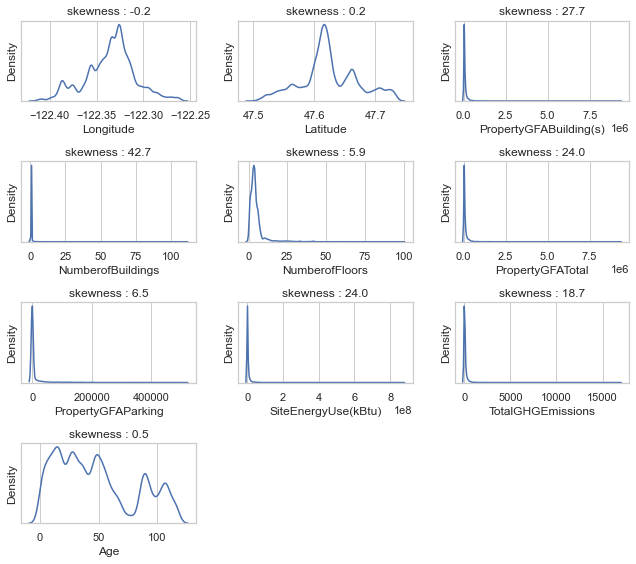

In [126]:
densite(df_selected[num_var])

#### NumberofBuildings

In [127]:
df_selected['NumberofBuildings'].map(lambda x: np.log1p(x)).skew()

5.050259456312428

In [128]:
df_selected['NumberofBuildings'].map(lambda x: np.sqrt(x)).skew()

10.476489803682314

In [129]:
df_selected['NumberofBuildings'].map(lambda x: 1 / (x+1)).skew()

2.8023197280343197

In [130]:
from scipy.stats import boxcox

In [131]:
pd.Series(boxcox(df_selected['NumberofBuildings'] + 1, lmbda=None)[0]).skew()

-0.8538846226182278

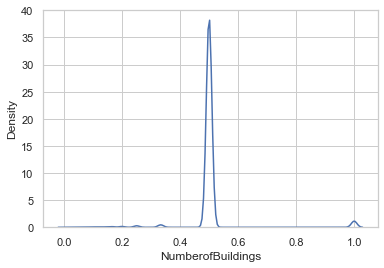

In [132]:
sns.distplot(df_selected['NumberofBuildings'].map(lambda x: 1 / (x+1))
            ,hist=False, kde_kws={'bw':0.1});

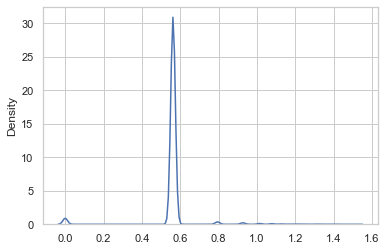

In [133]:
sns.distplot(boxcox(df_selected['NumberofBuildings'] + 1, lmbda=None)[0]
            ,hist=False, kde_kws={'bw':0.1});

#### PropertyGFABuilding

In [134]:
df_selected['PropertyGFABuilding(s)'].map(lambda x: np.log(x)).skew()

1.1776692583426045

In [135]:
df_selected['PropertyGFABuilding(s)'].map(lambda x: np.sqrt(x)).skew()

4.397929313428955

In [136]:
df_selected['PropertyGFABuilding(s)'].map(lambda x: 1 / (x)).skew()

1.6580676100159202

In [137]:
pd.Series(boxcox(df_selected['NumberofFloors'] + 1, lmbda=None)[0]).skew()

-0.04682661245180455

In [138]:
len(pd.Series(boxcox(df_selected['NumberofFloors'] + 1, lmbda=None)[0]))

3269

#### 

In [139]:
def skew_selector(df, var, zero=False):
    if zero == False:
        print(f"log : {df[var].map(lambda x: np.log1p(x)).skew()}\n\
racine : {df[var].map(lambda x: np.sqrt(x)).skew()}\n\
inverse : {df[var].map(lambda x: 1 / (x + 1)).skew()}\n\
boxcoc : {pd.Series(boxcox(df[var] + 1, lmbda=None)[0]).skew()}\n\
initiale : {df[var].skew()}")
    else:
        print(f"log : {df[var].map(lambda x: np.log(x)).skew()}\n\
racine : {df[var].map(lambda x: np.sqrt(x)).skew()}\n\
inverse : {df[var].map(lambda x: 1 / x).skew()}\n\
boxcoc : {pd.Series(boxcox(df[var], lmbda=None)[0]).skew()}\n\
initiale : {df[var].skew()}")

In [140]:
skew_selector(df_selected, 'NumberofBuildings')

log : 5.050259456312428
racine : 10.476489803682314
inverse : 2.8023197280343197
boxcoc : -0.8538846226182278
initiale : 42.68206181735583


In [141]:
skew_selector(df_selected, 'PropertyGFABuilding(s)')

log : 1.1777002991805219
racine : 4.397929313428955
inverse : 1.6570893091696162
boxcoc : 0.07709828865115549
initiale : 27.661631495453634


In [142]:
skew_selector(df_selected, 'NumberofFloors')

log : 0.8201711333450966
racine : 2.3344228399044478
inverse : 1.4656060009764262
boxcoc : -0.04682661245180455
initiale : 5.881396761466622


In [143]:
skew_selector(df_selected, 'PropertyGFATotal')

log : 1.1599584299640273
racine : 3.951586313218891
inverse : 0.26528857028287134
boxcoc : 0.1874309333660226
initiale : 23.995671798482306


In [144]:
skew_selector(df_selected, 'PropertyGFAParking')

log : 1.9681417781196149
racine : 3.395626744751516
inverse : -1.8936351960158817
boxcoc : 1.8937575212297242
initiale : 6.4957738054877385


In [145]:
skew_selector(df_selected, 'Age')

log : -0.9256886035855654
racine : -0.06470456266947058
inverse : 3.6888257957880413
boxcoc : -0.12383291335228155
initiale : 0.5369720666752658


In [146]:
skew_selector(df_selected, 'SiteEnergyUse(kBtu)')

log : 0.7296263397622501
racine : 5.3505102898616785
inverse : 21.849461996845505
boxcoc : -0.04831340106455092
initiale : 24.03961174298406


In [147]:
skew_selector(df_selected, 'TotalGHGEmissions')

log : 0.3926669398191387
racine : 5.320152595810405
inverse : 22.34397558699178
boxcoc : 0.02293665938211938
initiale : 18.696467300547518


In [148]:
df_selected['BuildingType'].unique()

array(['Multifamily LR (1-4)', 'NonResidential', 'SPS-District K-12',
       'Multifamily MR (5-9)', 'Campus', 'Nonresidential COS',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [149]:
df_selected.loc[(df_selected['BuildingType'] != 'Multifamily LR (1-4)')
                & (df_selected['BuildingType'] != 'Multifamily MR (5-9)')
                & (df_selected['BuildingType'] != 'Multifamily HR (10+)'), 'BuildingType'].unique()

array(['NonResidential', 'SPS-District K-12', 'Campus',
       'Nonresidential COS', 'Nonresidential WA'], dtype=object)

In [150]:
df_selected_nonRes = df_selected.loc[(df_selected['BuildingType'] != 'Multifamily LR (1-4)')
                & (df_selected['BuildingType'] != 'Multifamily MR (5-9)')
                & (df_selected['BuildingType'] != 'Multifamily HR (10+)')]

In [151]:
df_final = df_selected.copy()

In [152]:
df_final_nonRes = df_selected_nonRes.copy()

In [95]:
df_selected.to_csv('df.csv', index=False)

In [153]:
df_final.shape

(3269, 63)

In [154]:
# df_final['NumberofBuildings'] = np.log1p(df_final['NumberofBuildings'])
# df_final['PropertyGFABuilding(s)'] = np.log1p(df_final['PropertyGFABuilding(s)'])
# df_final['NumberofFloors'] = np.log1p(df_final['NumberofFloors'])
# df_final['PropertyGFATotal'] = np.log1p(df_final['PropertyGFATotal'])
# df_final['PropertyGFAParking'] = np.log1p(df_final['PropertyGFAParking'])
# df_final['TotalGHGEmissions'] = np.log1p(df_final['TotalGHGEmissions'])
# df_final['SiteEnergyUse(kBtu)'] = np.log1p(df_final['SiteEnergyUse(kBtu)'])

In [155]:
# df_final['TotalGHGEmissions'] = df_final['TotalGHGEmissions'] + 0.81

In [156]:
df_final['NumberofBuildings'] = boxcox(df_final['NumberofBuildings'] + 1, lmbda=None)[0]
df_final['PropertyGFABuilding(s)'] = boxcox(df_final['PropertyGFABuilding(s)'] + 1, lmbda=None)[0]
df_final['NumberofFloors'] = boxcox(df_final['NumberofFloors'] + 1, lmbda=None)[0]
df_final['PropertyGFATotal'] = boxcox(df_final['PropertyGFATotal'] + 1, lmbda=None)[0]
df_final['PropertyGFAParking'] = boxcox(df_final['PropertyGFAParking'] + 1, lmbda=None)[0]
df_final['Age'] = boxcox(df_final['Age'] + 1, lmbda=None)[0]
# df_final['TotalGHGEmissions'] = boxcox(df_final['TotalGHGEmissions'] + 1, lmbda=None)[0]
# df_final['SiteEnergyUse(kBtu)'] = boxcox(df_final['SiteEnergyUse(kBtu)'] + 1, lmbda=None)[0]

In [157]:
df_final['TotalGHGEmissions'] = np.log1p(df_final['TotalGHGEmissions'])
df_final['SiteEnergyUse(kBtu)'] = np.log1p(df_final['SiteEnergyUse(kBtu)'])

In [158]:
df_final_nonRes['NumberofBuildings'] = boxcox(df_final_nonRes['NumberofBuildings'] + 1, lmbda=None)[0]
df_final_nonRes['PropertyGFABuilding(s)'] = boxcox(df_final_nonRes['PropertyGFABuilding(s)'] + 1, lmbda=None)[0]
df_final_nonRes['NumberofFloors'] = boxcox(df_final_nonRes['NumberofFloors'] + 1, lmbda=None)[0]
df_final_nonRes['PropertyGFATotal'] = boxcox(df_final_nonRes['PropertyGFATotal'] + 1, lmbda=None)[0]
df_final_nonRes['PropertyGFAParking'] = boxcox(df_final_nonRes['PropertyGFAParking'] + 1, lmbda=None)[0]
df_final_nonRes['Age'] = boxcox(df_final_nonRes['Age'] + 1, lmbda=None)[0]
# df_final['TotalGHGEmissions'] = boxcox(df_final['TotalGHGEmissions'] + 1, lmbda=None)[0]
# df_final['SiteEnergyUse(kBtu)'] = boxcox(df_final['SiteEnergyUse(kBtu)'] + 1, lmbda=None)[0]

In [159]:
df_final_nonRes['TotalGHGEmissions'] = np.log1p(df_final_nonRes['TotalGHGEmissions'])
df_final_nonRes['SiteEnergyUse(kBtu)'] = np.log1p(df_final_nonRes['SiteEnergyUse(kBtu)'])

In [160]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3269 entries, 46 to 6599
Data columns (total 63 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Longitude                    3269 non-null   float64
 1   Neighborhood                 3269 non-null   object 
 2   BuildingType                 3269 non-null   object 
 3   TotalGHGEmissions            3269 non-null   float64
 4   ComplianceStatus             3269 non-null   object 
 5   PropertyGFAParking           3269 non-null   float64
 6   CouncilDistrictCode          3269 non-null   object 
 7   PropertyGFABuilding(s)       3269 non-null   float64
 8   OSEBuildingID                3269 non-null   int64  
 9   SiteEnergyUse(kBtu)          3269 non-null   float64
 10  PropertyGFATotal             3269 non-null   float64
 11  NumberofBuildings            3269 non-null   float64
 12  Latitude                     3269 non-null   float64
 13  NumberofFloors   

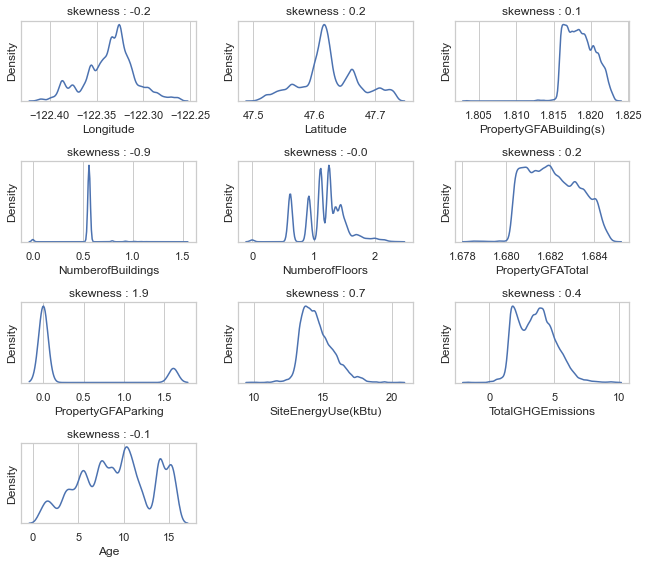

In [161]:
densite(df_final[num_var])

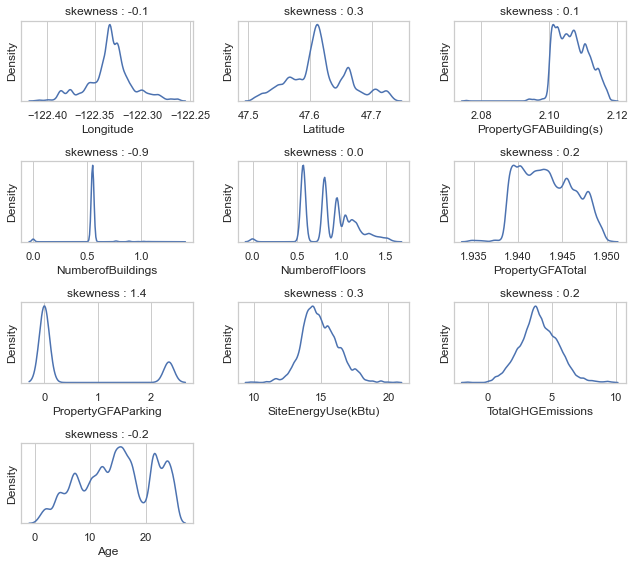

In [162]:
densite(df_final_nonRes[num_var])

In [163]:
shapiro(df.loc[df['NumberofFloors'].notnull(), 'NumberofFloors'])

ShapiroResult(statistic=0.5087215900421143, pvalue=0.0)

In [164]:
shapiro(df_final.loc[df_final['NumberofFloors'].notnull(), 'NumberofFloors'])

ShapiroResult(statistic=0.9526376128196716, pvalue=2.665855442961482e-31)

In [165]:
shapiro(df.loc[df['NumberofBuildings'].notnull(), 'NumberofBuildings'])

ShapiroResult(statistic=0.04533416032791138, pvalue=0.0)

In [166]:
shapiro(df_final.loc[df_final['NumberofBuildings'].notnull(), 'NumberofBuildings'])

ShapiroResult(statistic=0.29380321502685547, pvalue=0.0)

In [167]:
df_selected['SiteEnergyUse(kBtu)'].min()

17150.0

In [168]:
df_selected['TotalGHGEmissions'].sort_values()

6432       -0.80
4568        0.00
3766        0.00
2164        0.12
1276        0.17
          ...   
3380     8145.52
3426    10734.57
6499    11140.56
3870    12307.16
3291    16870.98
Name: TotalGHGEmissions, Length: 3269, dtype: float64

In [169]:
df_final['TotalGHGEmissions'].sort_values()

6432   -1.609438
4568    0.000000
3766    0.000000
2164    0.113329
1276    0.157004
          ...   
3380    9.005346
3426    9.281318
6499    9.318438
3870    9.418018
3291    9.733410
Name: TotalGHGEmissions, Length: 3269, dtype: float64

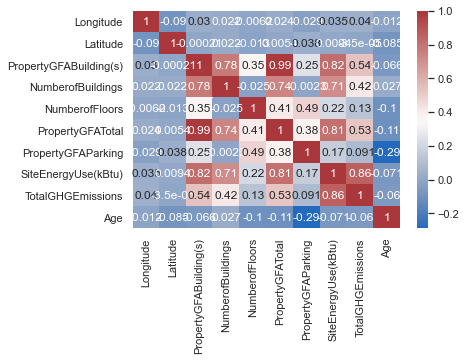

In [170]:
sns.heatmap(df_selected_nonRes[num_var].corr()
           ,cmap='vlag'
           ,annot=True);

In [171]:
df_selected_nonRes[num_var].corr()['SiteEnergyUse(kBtu)'].sort_values(ascending=False)

SiteEnergyUse(kBtu)       1.000000
TotalGHGEmissions         0.862345
PropertyGFABuilding(s)    0.823124
PropertyGFATotal          0.809610
NumberofBuildings         0.713273
NumberofFloors            0.216793
PropertyGFAParking        0.166997
Longitude                 0.035378
Latitude                  0.009397
Age                      -0.071349
Name: SiteEnergyUse(kBtu), dtype: float64

In [172]:
df_selected_nonRes[num_var].corr()['TotalGHGEmissions'].sort_values(ascending=False)

TotalGHGEmissions         1.000000
SiteEnergyUse(kBtu)       0.862345
PropertyGFABuilding(s)    0.541313
PropertyGFATotal          0.529690
NumberofBuildings         0.420198
NumberofFloors            0.128185
PropertyGFAParking        0.091208
Longitude                 0.039792
Latitude                 -0.000035
Age                      -0.059504
Name: TotalGHGEmissions, dtype: float64

In [173]:
df_final_nonRes.to_csv('df_clean_nonRes.csv', index=False)

In [174]:
df_final.to_csv('df_clean.csv', index=False)

In [175]:
import dill
dill.dump_session('kernels/p4_explor_kernel.db')